# Airline Passenger Satisfaction

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report

2024-04-22 23:01:46.660920: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Path to the CSV files
airline_passenger_satisfaction_train = "../data/raw/train.csv"
airline_passenger_satisfaction_test = "../data/raw/test.csv"

# Read CSV files and convert to DataFrame
train = pd.read_csv(airline_passenger_satisfaction_train)
test = pd.read_csv(airline_passenger_satisfaction_test)

## Nettoyage et analyse exploratoire des données 

In [4]:
train.shape

(103904, 25)

In [5]:
train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

### To prepare the data for model training, we need to perform the following actions on the training dataset :

Encoding of categorical variables: Machine learning algorithms require numerical data. Therefore, we need to convert categorical variables into numerical ones using techniques such as one-hot encoding or label encoding.

Removal of unnecessary columns: Some columns, such as 'Unnamed:0' and 'id', are not relevant for prediction and can be removed to simplify the dataset.

In [7]:
def process_data(df):
    # Remove unnecessary columns
    df = df.drop(['Unnamed: 0', 'id'], axis=1)
    
    # Replace categorical values with numerical values
    df['Gender'] = df['Gender'].replace({'Female': 1, 'Male': 0})
    df['Customer Type'] = df['Customer Type'].replace({'Loyal Customer': 1, 'disloyal Customer': 0})
    df['Type of Travel'] = df['Type of Travel'].replace({'Business travel': 1, 'Personal Travel': 0})
    df['Class'] = df['Class'].replace({'Business': 2, 'Eco Plus': 1, 'Eco': 0})
    df['satisfaction'] = df['satisfaction'].replace({'satisfied': 1, 'neutral or dissatisfied': 0})
    
    # Replace missing values in 'Arrival Delay in Minutes' with the median
    df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median(), inplace=True)
    
    return df

train = process_data(train)
test = process_data(test)


/var/folders/ry/5ql0hhr50zn1y9h9kmjyvxkm0000gn/T/ipykernel_28883/4200931425.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].replace({'Female': 1, 'Male': 0})
/var/folders/ry/5ql0hhr50zn1y9h9kmjyvxkm0000gn/T/ipykernel_28883/4200931425.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Customer Type'] = df['Customer Type'].replace({'Loyal Customer': 1, 'disloyal Customer': 0})
/var/folders/ry/5ql0hhr50zn1y9h9kmjyvxkm0000gn/T/ipykernel_28883/4200931425.py:8: FutureWarning: Downcasting behavior in 

In [8]:
# Save processed data
train.to_csv("../data/processed/train_processed.csv", index=False)
test.to_csv("../data/processed/test_processed.csv", index=False)

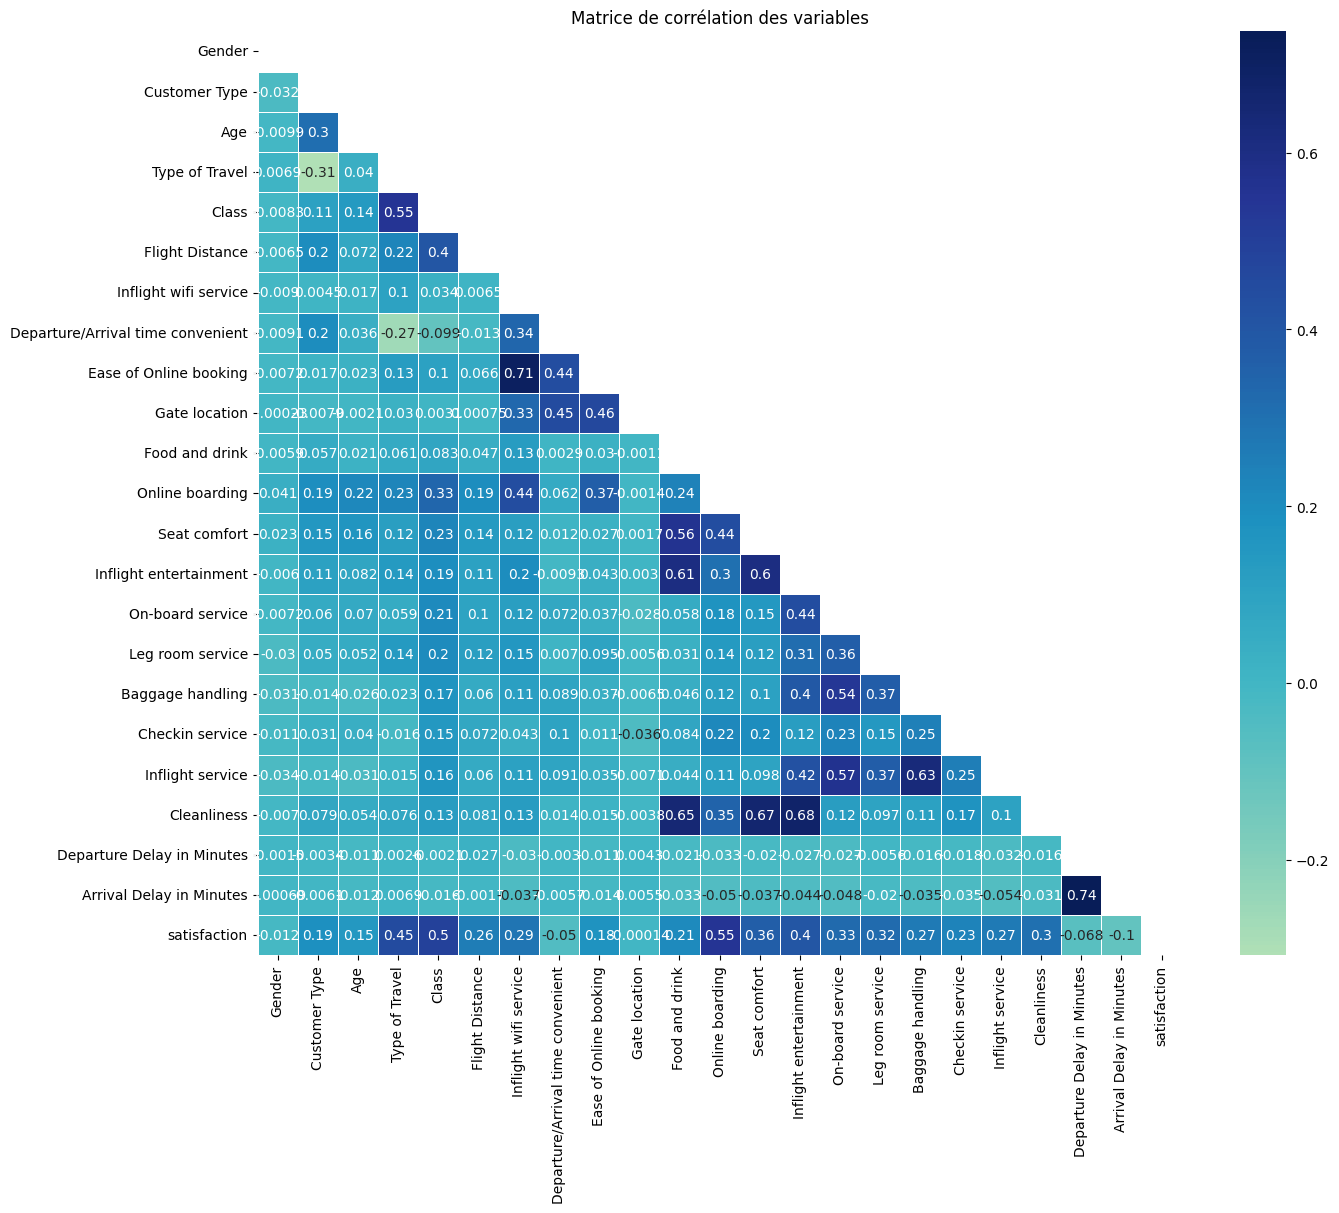

In [9]:
# Calculating the correlation matrix
corr = train.corr(method='spearman')


mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 12))

sns.heatmap(corr, annot=True, mask=mask, cmap="YlGnBu", center=0,
            square=True, linewidths=.5)
plt.title("Matrice de corrélation des variables")

plt.show()

## Model Building

In [10]:
# Splitting features and target
X = train.drop('satisfaction', axis=1)
y = train['satisfaction']

In [11]:
# Normalizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Splitting training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [13]:
# Creating the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/opt/anaconda3/envs/Airline-Passenger-Satisfaction/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Training the model
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_val, y_val), verbose=2)

Epoch 1/25
1299/1299 - 4s - 3ms/step - accuracy: 0.8724 - loss: 0.3184 - val_accuracy: 0.9277 - val_loss: 0.1845
Epoch 2/25
1299/1299 - 2s - 1ms/step - accuracy: 0.9154 - loss: 0.2136 - val_accuracy: 0.9373 - val_loss: 0.1581
Epoch 3/25
1299/1299 - 2s - 2ms/step - accuracy: 0.9252 - loss: 0.1872 - val_accuracy: 0.9456 - val_loss: 0.1386
Epoch 4/25
1299/1299 - 2s - 1ms/step - accuracy: 0.9333 - loss: 0.1664 - val_accuracy: 0.9502 - val_loss: 0.1206
Epoch 5/25
1299/1299 - 2s - 2ms/step - accuracy: 0.9400 - loss: 0.1519 - val_accuracy: 0.9534 - val_loss: 0.1131
Epoch 6/25
1299/1299 - 2s - 2ms/step - accuracy: 0.9440 - loss: 0.1417 - val_accuracy: 0.9556 - val_loss: 0.1061
Epoch 7/25
1299/1299 - 2s - 1ms/step - accuracy: 0.9464 - loss: 0.1344 - val_accuracy: 0.9554 - val_loss: 0.1050
Epoch 8/25
1299/1299 - 2s - 1ms/step - accuracy: 0.9473 - loss: 0.1327 - val_accuracy: 0.9568 - val_loss: 0.1018
Epoch 9/25
1299/1299 - 2s - 1ms/step - accuracy: 0.9494 - loss: 0.1268 - val_accuracy: 0.9571 - 

## Model Performance Evaluation

In [16]:
# Evaluating the model on test data
X_test = scaler.transform(test.drop('satisfaction', axis=1))
y_test = test['satisfaction']
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9599 - loss: 0.0921
Test accuracy: 0.9602324962615967
Test loss: 0.09223320335149765


In [18]:
# Predicting on test data
predictions = model.predict(X_test)

# Converting predictions to classes (0 or 1)
predicted_classes = (predictions > 0.5).astype(int)

# Displaying classification report
print(classification_report(y_test, predicted_classes))

812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     14573
           1       0.97      0.93      0.95     11403

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976



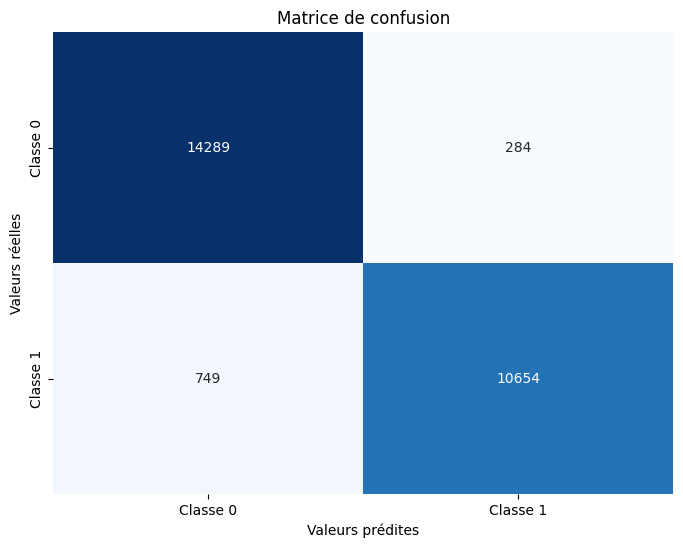

In [19]:
# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions.round())

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()

## Conclusion 

**In this classification report, precision, recall, and F1 scores are provided for two distinct classes:**

Class 0: Represents passengers whose satisfaction is classified as "neutral or dissatisfied." The precision for this class is 0.94, recall is 0.98, and the F1 score is 0.96.

Class 1: Represents passengers whose satisfaction is classified as "satisfied." The precision for this class is 0.97, recall is 0.92, and the F1 score is 0.95.

These metrics indicate that the model performs highly in predicting passenger satisfaction, with balanced scores across both classes. The overall accuracy of the model is 0.96, which means it correctly predicts the class for about 96% of the instances in the test set. This demonstrates the model's effectiveness in distinguishing between satisfied and dissatisfied passengers, highlighting its potential utility in improving service quality and customer experience.

*notebook was created by Sofiane EL FARTASS.*